# Generating images using GAN in TensorFlow



Let's strengthen our understanding of GANs by building them to generate images of handwritten digits in Tensorflow.

## Import libraries

First, we will import all the necessary libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()

### Read the Dataset

Load the MNIST dataset:

In [2]:
data = input_data.read_data_sets("data/mnist",one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


Let's plot one image:

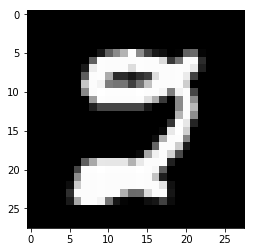

In [3]:
plt.imshow(data.train.images[13].reshape(28,28),cmap="gray")

## Defining Generator 

Generator $G$ takes the noise $z$ as an input and returns an image. We define the generator as a feedforward network with three layers. Instead of coding the generator network from scratch, we can use tf.layers.dense() which can be used to create a dense layer. It takes three parameters: inputs, number of units and the activation function. 

In [4]:
def generator(z,reuse=None):
    
    with tf.variable_scope('generator',reuse=reuse):
        
        hidden1 = tf.layers.dense(inputs=z,units=128,activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        output = tf.layers.dense(inputs=hidden2,units=784,activation=tf.nn.tanh)
        
        return output

## Defining Discriminator

We know that discriminator $D$ returns the probability. i.e it will tell us the probability of the given image being real. We define the discriminator also as a feed forward network with 3 layers:

In [5]:
def discriminator(X,reuse=None):
    
    with tf.variable_scope('discriminator',reuse=reuse):
        
        hidden1 = tf.layers.dense(inputs=X,units=128,activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(inputs=hidden2,units=1)
        output = tf.sigmoid(logits)
        
        return logits

## Define the input placeholders


Now, we define the placeholder for the input $x$ and the noise $z$. 

In [6]:
x = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

## Start the GAN!

First, we feed the noise $z$ to the generator and it will output the fake image. i.e $ fake \; x = G(z) $:

In [7]:
fake_x = generator(z)

Now, we feed the real image to the discriminator $D(x)$ and get the probabillty of the image being real:

In [8]:
D_logits_real = discriminator(x) 

Similarly, we feed the fake image to the discriminator $D(z)$ and get the probabillty of the image being real:

In [9]:
D_logits_fake = discriminator(fake_x,reuse=True) 

## Computing Loss Function

Now, we will see, how to compute the loss function.



### Discriminator Loss

Discriminator loss is given as,

${L ^{D} =  - \mathbb{E}_{x \sim p_{r}(x)}[\log D(x)] - \mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z))]} $


<br>

__First term__

The first term i.e - $\mathbb{E}_{x \sim p_{r}(x)}[\log D(x)]$ implies the expectations of the log likelihood of images sampled from the real data distribution being real.


It is basically the binary cross entropy loss. We can implement binary cross entropy loss with tensorflow function tf.nn.sigmoid_cross_entropy_with_logits().  It takes two parameters as inputs: logits and labels. 


* Logits, as the name suggests, it is the logits of the network so it is D_logits_real. 

* Labels, as the name suggests, it is the true label. We learned that discriminator should return 1 for real image and 0 for fake image. Since we are calculating the loss for input images sampled from the real data distribution, the true label is 1. 


We use tf.ones_likes() for setting the labels to 1 with the same shape as D_logits_real. That is, labels = tf.ones_like(D_logits_real)


Then we compute the mean loss using tf.reduce_mean(). If you notice, there is a minus sign in our loss function which we added for converting our loss to a minimization objective. But, in the below code, there is no minus sign, Because tensorflow optimizers will only minimize and not maximize. So we don't have to add minus sign in our implementation because anyways it will be minimized by the tensorflow optimizer. 

In [10]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real,
                                                                     labels=tf.ones_like(D_logits_real)))

__Second Term__


The second term, - $\mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z))]$  implies the expectations of the log likelihood of images generated by the generator being fake. 


Similar to the first term we can use tf.nn.sigmoid_cross_entropy_with_logits() for caclauting the binary cross entorpy loss. 


Here, 

* Logits is the D_logits_fake

* Since we are calculating the loss for the fake images generated by the generator, the true label is 0.


We use tf.zeros_like() for setting the labels to 0 with the same shape as D_logits_fake. That is, labels = tf.zeros_like(D_logits_fake)

In [11]:
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake,
                                                                     labels=tf.zeros_like(D_logits_fake)))

__Final term__

So, combining the above two terms, loss function of the discriminator is given as:

In [12]:
D_loss = D_loss_real + D_loss_fake

### Generator Loss

Generator loss is given as, 

${L^{G}= - \mathbb{E}_{z \sim p_{z}(z)}[\log (D(G(z)))] } $


It implies the probability of the fake image being classified as a real image. As we calculated binary cross entropy in the discriminator, we use tf.nn.sigmoid_cross_entropy_with_logits() for calculating the loss.



Here,

* Logits is the D_logits_fake

* Labels: Since our loss implies the probability of the fake image being classified as real, the true label is 1. Because, as we learned, the goal of the generator is to generate the fake image and fool the discriminator to classify the fake image as a real image. 

We use tf.ones_like() for setting the labels to 1 with the same shape as D_logits_fake. That is, labels = tf.ones_like(D_logits_fake)


In [13]:
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake, 
                                                                labels=tf.ones_like(D_logits_fake)))

## Optimizing the Loss


Now we need to optimize our generator and discriminator. So, we collect the parameters of the discriminator and generator as $\theta_D$ and $\theta_G$ respectively. 

In [14]:
training_vars = tf.trainable_variables()

theta_D = [var for var in training_vars if 'dis' in var.name]
theta_G = [var for var in training_vars if 'gen' in var.name]

Optimize the loss using adam optimizer:

In [15]:
D_optimizer = tf.train.AdamOptimizer(0.001).minimize(D_loss,var_list = theta_D)
G_optimizer = tf.train.AdamOptimizer(0.001).minimize(G_loss, var_list = theta_G)

## Start the Training the GAN

Define the batch size, number of epochs and initialize all variables:

In [16]:
batch_size = 100
num_epochs = 1000

init = tf.global_variables_initializer()

### Generate Handwritten Digits

Start the tensorflow session and generate handwritten digits:

Epoch: 0, iteration: 549, Discriminator Loss:4.96056985855, Generator Loss: 0.880222082138


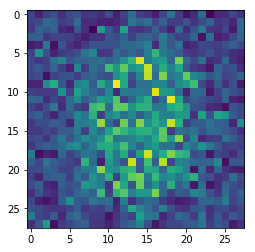

Epoch: 100, iteration: 549, Discriminator Loss:1.29050672054, Generator Loss: 0.897918999195


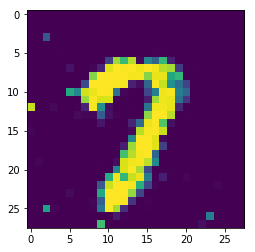

In [ ]:
with tf.Session() as session:
    
    
    #initialize all variables
    session.run(init)
    
    #for each epoch
    for epoch in range(num_epochs):
        
        #select number of batches
        num_batches = data.train.num_examples // batch_size
        
        #for each batch
        for i in range(num_batches):
            
            #get the batch of data according to the batch size
            batch = data.train.next_batch(batch_size)
            
            #reshape the data  
            batch_images = batch[0].reshape((batch_size,784))
            batch_images = batch_images * 2 - 1
            
            #sample batch noise
            batch_noise = np.random.uniform(-1,1,size=(batch_size,100))
            
            #define the feed dictionaries with input x as batch_images and noise z as batch noise
            feed_dict = {x: batch_images, z : batch_noise}

            
            #train discriminator and generator
            _ = session.run(D_optimizer,feed_dict = feed_dict)
            _ = session.run(G_optimizer,feed_dict = feed_dict)

            
            #compute loss of discriminator and generator
            discriminator_loss = D_loss.eval(feed_dict)
            generator_loss = G_loss.eval(feed_dict)
                      
            
        #feed the noise to a generator on every 100th epoch and generate an image
        if epoch%100==0:
            print("Epoch: {}, iteration: {}, Discriminator Loss:{}, Generator Loss: {}".format(epoch,i,discriminator_loss,generator_loss))
            
            #generate a fake image
            _fake_x = fake_x.eval(feed_dict)

            #plot the fake image generated by the generator
            plt.imshow(_fake_x[0].reshape(28,28))
            plt.show()              

Now that we learned how to generate images using GANs, in the next section we will learn about DCGAN which uses convolutional network instead of feedforward network in the generator and discriminator. 